In [1]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load dataset
wrld_df = pd.read_csv('world-happiness-report.csv')
wrld_df.shape

(1949, 11)

In [3]:
# display first five rows of dataframe
wrld_df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268


In [4]:
# check missing values
wrld_df.isna().sum()

Country name                          0
year                                  0
Life Ladder                           0
Log GDP per capita                   36
Social support                       13
Healthy life expectancy at birth     55
Freedom to make life choices         32
Generosity                           89
Perceptions of corruption           110
Positive affect                      22
Negative affect                      16
dtype: int64

In [5]:
# filling missing values with mean
cols_to_impute = ["Log GDP per capita","Social support","Healthy life expectancy at birth","Freedom to make life choices", "Generosity","Perceptions of corruption", "Positive affect", "Negative affect"]

imputer = SimpleImputer(strategy='mean')
for col in cols_to_impute:
    wrld_df[col] = imputer.fit_transform(wrld_df[[col]])

wrld_df.isna().sum()

Country name                        0
year                                0
Life Ladder                         0
Log GDP per capita                  0
Social support                      0
Healthy life expectancy at birth    0
Freedom to make life choices        0
Generosity                          0
Perceptions of corruption           0
Positive affect                     0
Negative affect                     0
dtype: int64

*We drop the year column since it's not relevant to the clustering analysis which is focused on the countries' happiness-related metrics*

In [6]:
# dropping year column.
wrld_df = wrld_df.drop('year', axis=1)

*Since we have multiple entries for each country over some years, we aggregate the data using the mean to obtain single record per country*

In [7]:
# aggregating using the mean...
agg_wrld_df = wrld_df.groupby('Country name').mean().reset_index()

In [8]:
# label ecoding for country names
countries = agg_wrld_df['Country name']
encoder = LabelEncoder()
countries_encoded = encoder.fit_transform(countries)

# reshape countries_encoeded
countries_encoded = countries_encoded.reshape(-1,1)

In [9]:
# features to use for clustering
features = agg_wrld_df.columns.difference(['country_encoded', 'Country name'])  #select the dataset except country_encoded and country name

# scaling the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(agg_wrld_df[features])

In [10]:
# concatenate scaled features and countries_encoded
features_scaled_with_countries = np.concatenate((features_scaled, countries_encoded), axis = 1)

### Elbow Method for Silhouette Score (KMeans)

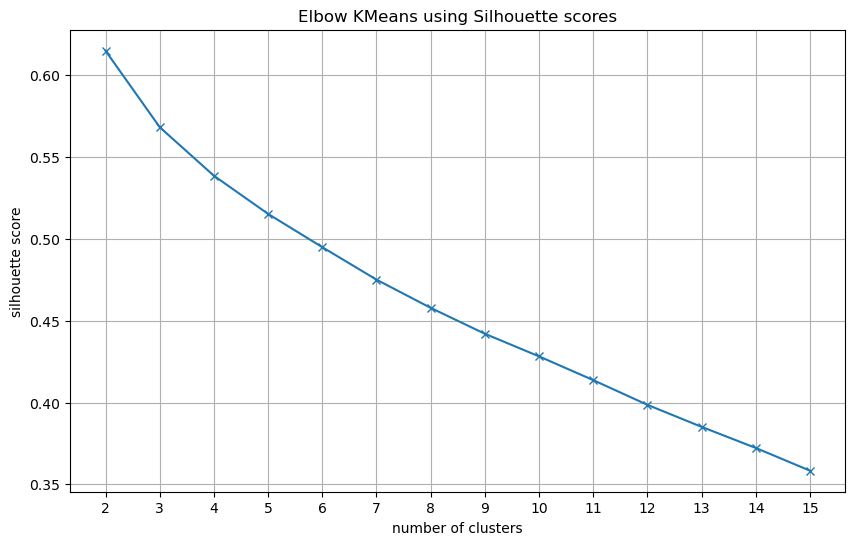

In [11]:
# silhouette score calculation
silhouette_scores = []
cluster_range = range(2, 16)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_labels = kmeans.fit_predict(features_scaled_with_countries)
    silhouette_scores.append(silhouette_score(features_scaled_with_countries, kmeans_labels))

# plotting the scores
plt.figure(figsize=(10,6))
plt.plot(cluster_range, silhouette_scores, marker='x')
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.xticks(np.arange(2, 16, step=1))
plt.title("Elbow KMeans using Silhouette scores")
plt.grid(True)
plt.show()

In [12]:
# determine the optimal clusters
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print("Optimal numer of clusters: ", optimal_clusters)

Optimal numer of clusters:  2


In [13]:
# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_data = pca.fit_transform(features_scaled_with_countries)

# Create a DataFrame for the PCA data
pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])
pca_df

,PC1,PC2
0,82.516355,3.920009
1,81.506127,0.623194
2,80.503495,0.311045
3,79.512026,2.542149
4,78.496032,-1.692729
...,...,...
161,-78.500926,-0.484096
162,-79.502014,-0.007187
163,-80.489025,3.084582
164,-81.495120,1.966870


### KMeans Clustering (with optimal clusters)

In [14]:
# KMeans with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(features_scaled_with_countries)

# Silhouette score for KMeans
kmeans_score = silhouette_score(features_scaled_with_countries, kmeans_labels)
print("KMeans Silhouette score:", kmeans_score)

KMeans Silhouette score: 0.614988237163056


In [15]:
# KMeans with PCA

# KMeans with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(pca_data)

# Silhouette score for KMeans
kmeans_score = silhouette_score(pca_data, kmeans_labels)
print("PCA KMeans Silhouette score:", kmeans_score)

PCA KMeans Silhouette score: 0.6184559036608107


### Analysis Section

In [16]:
# add cluster labels to aggregated data
agg_wrld_df['cluster'] = kmeans_labels

*We want to determine which of the clusters is happier by finding the total positive affect scores in each cluster*

In [30]:
# Calculate total Positive affect per cluster for KMeans clustering
positive_affect_per_cluster = agg_wrld_df.groupby('cluster')['Positive affect'].sum()

# Determine the happiest KMeans cluster
happiest_cluster = positive_affect_per_cluster.idxmax()
happiest_value = positive_affect_per_cluster.max()

print(f'The happiest cluster is Cluster {happiest_cluster} with total Positive affect: {happiest_value}')


The happiest cluster is Cluster 0 with total Positive affect: 59.853773738760516


*Find the number of countries in cluster 0*

In [42]:
# Filter countries in the happiest cluster
countries_in_cluster_0 = agg_wrld_df[agg_wrld_df['cluster'] == happiest_cluster]['Country name'].tolist()

# display the number of happy countries from analysis
num_of_countries = len(countries_in_cluster_0)
print(f'Number of countries in cluster 0: {num_of_countries}')

# Print the countries
print(f'Countries in cluster 0:...')
for country in countries_in_cluster_0:
    print(country)


Number of countries in cluster 0: 84
Countries in cluster 0:...
Lesotho
Liberia
Libya
Lithuania
Luxembourg
Madagascar
Malawi
Malaysia
Maldives
Mali
Malta
Mauritania
Mauritius
Mexico
Moldova
Mongolia
Montenegro
Morocco
Mozambique
Myanmar
Namibia
Nepal
Netherlands
New Zealand
Nicaragua
Niger
Nigeria
North Cyprus
North Macedonia
Norway
Oman
Pakistan
Palestinian Territories
Panama
Paraguay
Peru
Philippines
Poland
Portugal
Qatar
Romania
Russia
Rwanda
Saudi Arabia
Senegal
Serbia
Sierra Leone
Singapore
Slovakia
Slovenia
Somalia
Somaliland region
South Africa
South Korea
South Sudan
Spain
Sri Lanka
Sudan
Suriname
Swaziland
Sweden
Switzerland
Syria
Taiwan Province of China
Tajikistan
Tanzania
Thailand
Togo
Trinidad and Tobago
Tunisia
Turkey
Turkmenistan
Uganda
Ukraine
United Arab Emirates
United Kingdom
United States
Uruguay
Uzbekistan
Venezuela
Vietnam
Yemen
Zambia
Zimbabwe


*Example case: check if Ghana is in cluster 0*

In [39]:
country_to_check = 'Ghana'

# Filter and check if the country is in the specified KMeans cluster
is_in_cluster = agg_wrld_df[(agg_wrld_df['cluster'] == happiest_cluster) & (agg_wrld_df['Country name'] == country_to_check)].shape[0] > 0

if is_in_cluster:
    print(f'{country_to_check} is in Cluster {happiest_cluster}')
else:
    print(f'{country_to_check} is not in Cluster {happiest_cluster}')

Ghana is not in Cluster 0


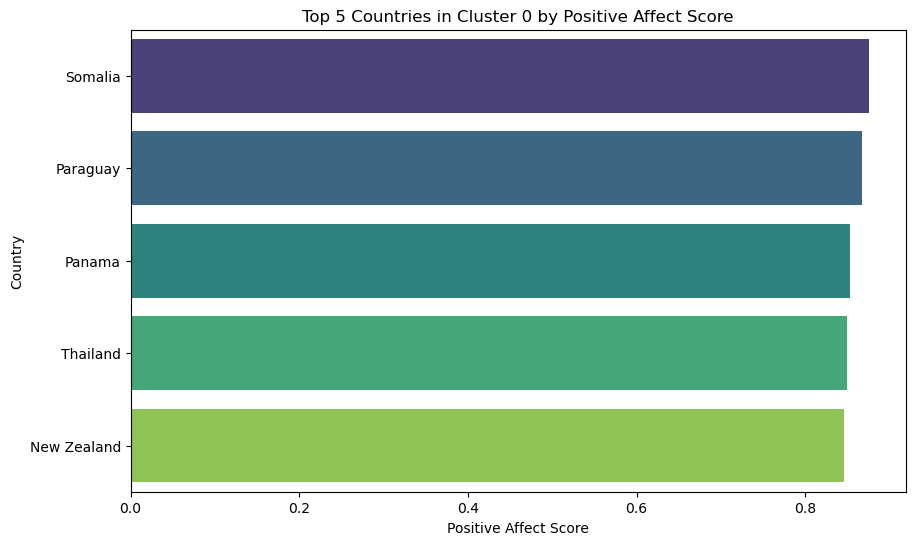

In [40]:
# top 5 countries in cluster 0

# Filter the DataFrame for Cluster 0
cluster0_df = agg_wrld_df[agg_wrld_df['cluster'] == happiest_cluster]

# Sort the DataFrame by 'Positive affect' in descending order to get top 5 countries
top_5_countries = cluster0_df.nlargest(5, 'Positive affect')

# Visualize the top 5 countries by positive affect score
plt.figure(figsize=(10, 6))
sns.barplot(x='Positive affect', y='Country name', data=top_5_countries, palette='viridis')
plt.title(f'Top 5 Countries in Cluster {happiest_cluster} by Positive Affect Score')
plt.xlabel('Positive Affect Score')
plt.ylabel('Country')
plt.show()

*Find the total positive affect in cluster 1 as well as the number of countries*

In [45]:
# Filter countries in the other cluster
cluster_1 = 1
countries_in_cluster_1 = agg_wrld_df[agg_wrld_df['cluster'] == cluster_1]['Country name'].tolist()

# Calculate total Positive affect for Cluster 1
total_positive_affect_cluster_1 = agg_wrld_df[agg_wrld_df['cluster'] == cluster_1]['Positive affect'].sum()
print(f'Total Positive affect in cluster {cluster_1}: {total_positive_affect_cluster_1}')

# display the number of happy countries from analysis
num_of_countries = len(countries_in_cluster_1)
print(f'Number of countries in cluster 1: {num_of_countries}')

# Print the countries
print(f'Countries in cluster 1:...')
for country in countries_in_cluster_1:
    print(country)

Total Positive affect in cluster 1: 57.768436820329526
Number of countries in cluster 1: 82
Countries in cluster 1:...
Afghanistan
Albania
Algeria
Angola
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahrain
Bangladesh
Belarus
Belgium
Belize
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
Bulgaria
Burkina Faso
Burundi
Cambodia
Cameroon
Canada
Central African Republic
Chad
Chile
China
Colombia
Comoros
Congo (Brazzaville)
Congo (Kinshasa)
Costa Rica
Croatia
Cuba
Cyprus
Czech Republic
Denmark
Djibouti
Dominican Republic
Ecuador
Egypt
El Salvador
Estonia
Ethiopia
Finland
France
Gabon
Gambia
Georgia
Germany
Ghana
Greece
Guatemala
Guinea
Guyana
Haiti
Honduras
Hong Kong S.A.R. of China
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland
Israel
Italy
Ivory Coast
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Kosovo
Kuwait
Kyrgyzstan
Laos
Latvia
Lebanon


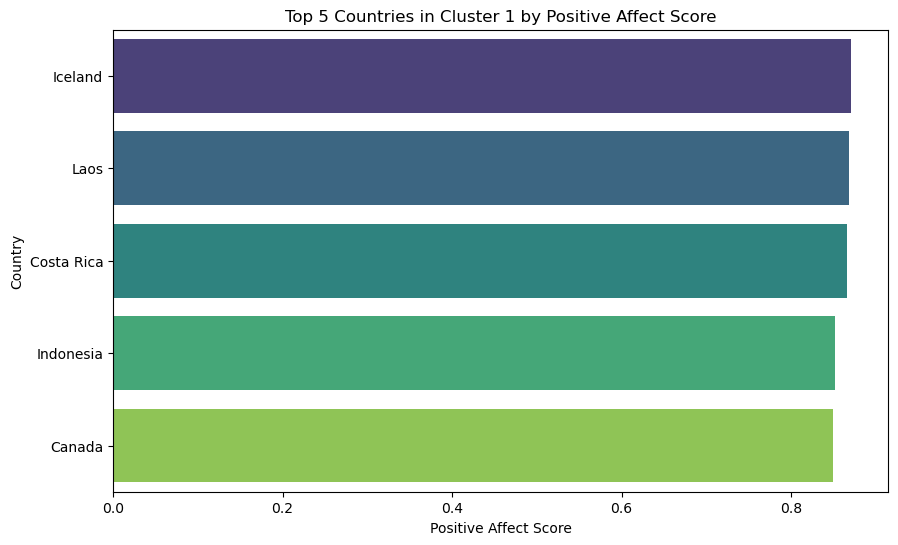

In [54]:
# top 5 countries in cluster 1

# Filter the DataFrame for Cluster 0
cluster1_df = agg_wrld_df[agg_wrld_df['cluster'] == cluster_1]

# Sort the DataFrame by 'Positive affect' in descending order to get top 5 countries
cluster_1_top_5_countries = cluster1_df.nlargest(5, 'Positive affect')

# Visualize the top 5 countries by positive affect score
plt.figure(figsize=(10, 6))
sns.barplot(x='Positive affect', y='Country name', data=cluster_1_top_5_countries, palette='viridis')
plt.title(f'Top 5 Countries in Cluster {cluster_1} by Positive Affect Score')
plt.xlabel('Positive Affect Score')
plt.ylabel('Country')
plt.show()

## Conclusion

*Cluster 0*, comprising 84 countries has on **average**, a higher positive affect score than that of *Cluster 1* based on all features considered.  
**Future Work:** Further analysis into features/factors that most influence happiness scores across countries